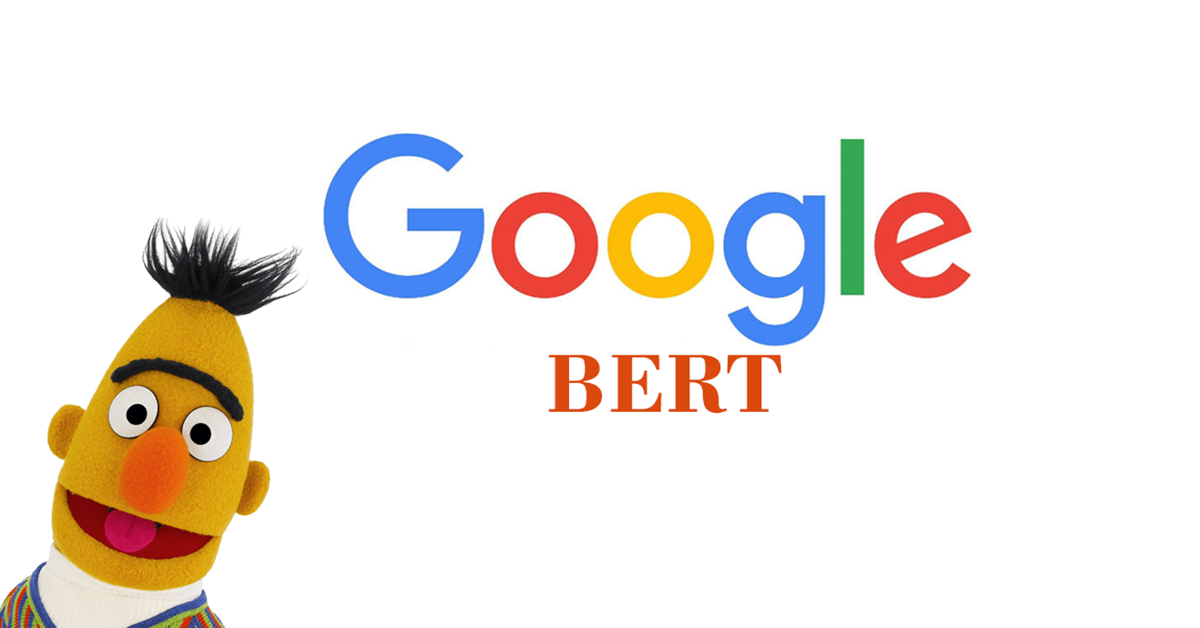

# Introduction
Sentiment analysis, also known as opinion mining, is a crucial task in Natural Language Processing (NLP). It involves determining the sentiment or emotion conveyed in a piece of text, typically classifying it as positive, neutral, or negative. In the context of e-commerce, sentiment analysis can help companies understand customer feedback, improve products, and enhance customer satisfaction.

In this notebook, we work with a dataset of e-commerce product reviews in the Turkish language, which are labeled into three classes: positive, neutral, and negative. The dataset provides an opportunity to explore various approaches to sentiment analysis and evaluate their performance.

Traditionally, many notebooks on platforms like Kaggle have employed simpler vectorization techniques such as TF-IDF (Term Frequency-Inverse Document Frequency) and CountVectorizer, often combined with machine learning models like Random Forest, Logistic Regression, or Support Vector Machines. These approaches, while effective to some extent, have shown accuracy rates in the range of 0.81 to 0.85.

In this notebook, we take a different approach by leveraging BERT (Bidirectional Encoder Representations from Transformers), a pre-trained language model that has revolutionized NLP due to its ability to understand context and capture semantic relationships in text. By fine-tuning a BERT model specifically for this sentiment analysis task, we achieved an accuracy score of 0.93, significantly outperforming the simpler models. This demonstrates the power of deep learning models like BERT in capturing complex patterns and nuances in language, even in relatively complex tasks like multi-class sentiment analysis.

Throughout this notebook, you'll find a detailed exploration of the data, an explanation of the preprocessing steps, and an overview of the fine-tuning process with BERT. Additionally, we compare the performance of our BERT-based model with that of simpler models to highlight the benefits of this approach. We conclude with a discussion on the results and potential future directions for enhancing sentiment analysis in the e-commerce domain.

## About BERT Model
BERT, or Bidirectional Encoder Representations from Transformers, is a breakthrough pre-trained language model developed by Google. It revolutionized Natural Language Processing (NLP) by introducing a bidirectional approach to language understanding, enabling it to capture context from both the left and right sides of a given word. BERT comes in various versions, including BERT-Base and BERT-Large, which differ in the number of transformer layers and attention heads. Beyond its use in sentiment analysis, BERT has demonstrated exceptional performance across a wide range of NLP tasks, such as text classification, named entity recognition, question answering, and text summarization. Its versatility and powerful context-aware capabilities make it a popular choice for complex NLP tasks, contributing to significant advancements in the field.

# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import torch
import transformers

warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))  # Lists GPU names
else:
    print("No GPUs found")

Tesla P100-PCIE-16GB


In [3]:
reviews = pd.read_csv("/kaggle/input/eticaret-urun-yorumlari/e-ticaret_urun_yorumlari.csv", on_bad_lines="skip", delimiter=";")
print(reviews.shape)
reviews.sample(5)

(15170, 2)


,Metin,Durum
14684,Ürünü teslim aldım ama içinde sarz aleti çıkma...,0
2719,Çok güzel harika,1
5560,rengi guzel kargo çok iyiydi,1
4244,Güzel ama geç geldi,1
14922,ürün radyolu yazıyor ama radyo yok,0


0: negative,  
1: positive,  
2: neutr

In [4]:
reviews.isna().sum()

Metin    0
Durum    0
dtype: int64

In [5]:
reviews.duplicated().sum()

1601

In [6]:
reviews.drop_duplicates(keep='first', inplace=True)

In [7]:
reviews.shape

(13569, 2)

In [8]:
reviews['Durum'].value_counts(normalize=True, dropna=False)

Durum
0    0.477854
1    0.427003
2    0.095143
Name: proportion, dtype: float64

In [9]:
X = reviews['Metin'].values
y = reviews['Durum'].values

In [10]:
X

array(['evet anlatıldığı gibi',
       'Daha öncede almıştım bu cihazdan ense ve sakal tüketmek için on numara sıfıra yakın alıyor',
       'Ürün gayet başarılı sakal kesmede başlık sayısı biraz daha fazla olabilirdi.Hem 0 a yakın aliyor. hem de kirli sakal için 3 numara başlık ideal.',
       ..., '2 gün sonra hoparlörü bozuldu kullanışsız',
       'aşırı boğuk bir sesi ve rengi var kumanda hemen bozuldu.',
       'Kumanda çok kalitesiz verdiğiniz paraya değmez'], dtype=object)

In [11]:
y

array([1, 1, 1, ..., 0, 0, 0])

# Tokenization

We will be using the pretrained BERT model from this checkpoint:  
https://huggingface.co/dbmdz/bert-base-turkish-cased  

In [12]:
from transformers import BertForSequenceClassification, BertTokenizer

checkpoint_name = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(checkpoint_name)

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [13]:
# Lets observe the behaviour of our tokenizer
sample_input_ids = tokenizer.encode(X[0], add_special_tokens=True)
print(X[0])
print(sample_input_ids)
print("-"*100)

sample_input_ids_2 = tokenizer.encode(X[56], add_special_tokens=True)
print(X[56])
print(sample_input_ids_2)

evet anlatıldığı gibi
[2, 7027, 26528, 2200, 3]
----------------------------------------------------------------------------------------------------
philipsin tras makinesini kullanıyordum. Bu ürün şarj ve bıçak olarak philips'ten daha kaliteli. bosuna 3 kati fazla ödeyip marka almayin. cok iyi kesiyor sıfıra yakın
[2, 12152, 7770, 2756, 23826, 1022, 9101, 3926, 9489, 2881, 18, 2123, 2782, 10696, 1992, 9434, 2133, 12152, 7770, 1022, 11, 4713, 2171, 4977, 18, 24380, 2364, 23, 2312, 1024, 2578, 9211, 2136, 4766, 4471, 31471, 18, 6568, 2395, 11229, 2057, 8271, 1006, 3075, 3]


In [14]:
# Lets check the max length of our sentences in corpus

max_len = 0
max_token = []

for sentence in X:
    
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    max_token.append(len(input_ids))

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence TOKEN length: ', max_len)

Max sentence TOKEN length:  212


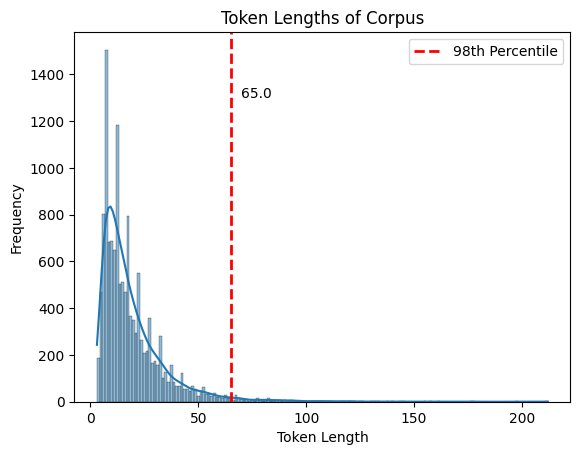

In [15]:
# Max Token Length is 212 but do we really need to tokenize upto 212 length

sns.histplot(max_token, kde=True)
percentile_98 = np.percentile(max_token, 98)
plt.axvline(x=percentile_98, color='r', linestyle='--', linewidth=2, label='98th Percentile')
plt.title("Token Lengths of Corpus")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.text(70, 1300,percentile_98)
plt.legend()
plt.show()

In [16]:
# Tokenize text with padding and truncation
tokenized_inputs = tokenizer(X.tolist(),  # Convert X array to a list of text
                           padding='max_length',  # Apply padding to max length
                           truncation=True,  # Truncate if length exceeds max
                           max_length=65,  # Max length of tokens
                           return_tensors='pt')  # Return as PyTorch tensors

# Prepare Data for Training

In [17]:
# lets extract input IDs and attention masks from tokenized data
input_ids = tokenized_inputs['input_ids']  # Token IDs for each text
attention_mask = tokenized_inputs['attention_mask']  # Attention masks

# lets convert the labels to Tensorflow tensors [also we can use to_categorical]
labels = torch.tensor(y, dtype=torch.long)

In [18]:
input_ids

tensor([[    2,  7027, 26528,  ...,     0,     0,     0],
        [    2,  3387,  2478,  ...,     0,     0,     0],
        [    2,  5435,  7982,  ...,     0,     0,     0],
        ...,
        [    2,    22,  2173,  ...,     0,     0,     0],
        [    2,  5869,  6176,  ...,     0,     0,     0],
        [    2, 26635,  1986,  ...,     0,     0,     0]])

In [19]:
attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [20]:
labels

tensor([1, 1, 1,  ..., 0, 0, 0])

In [21]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(input_ids, attention_mask, labels)

# Define the split size (90% training data)
split = 0.9
total_size = len(dataset)  # Get the total dataset size
train_size = int(total_size * split)
val_size = total_size - train_size  # Ensure sizes add up to the dataset length

# Split into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define DataLoaders for training and validation
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(type(train_dataloader), " ", len(train_dataloader))
print(type(val_dataloader), " ", len(val_dataloader))


<class 'torch.utils.data.dataloader.DataLoader'>   381
<class 'torch.utils.data.dataloader.DataLoader'>   42


# BERT Model

In [22]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch import nn
from tqdm import tqdm

## Load Pre-Trained Model

In [23]:
num_labels_ = 3
model = BertForSequenceClassification.from_pretrained(checkpoint_name, num_labels=num_labels_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Define Training Hyperparameters

In [24]:
# Use AdamW optimizer with a common learning rate for BERT fine-tuning
optimizer = AdamW(model.parameters(), lr=2e-5)     # 2e-5, 3e-5, 5e-5 possible

num_epochs = 3  # 1, 2, 3 is acceptable

# Total Steps and Warmup Steps
total_steps = num_epochs * len(train_dataloader)  # Total steps for learning rate schedule
warmup_percentage = 0.1
num_warmup_steps = int(total_steps * warmup_percentage)

# Create the Learning Rate Scheduler with Warm-up
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=total_steps)

# Define a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()


## Define a Training Loop

In [25]:
def train_epoch(model, train_dataloader, optimizer, loss_fn, scheduler, device, progress_bar=None):
    model.train()
    total_loss = 0
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        if progress_bar:
            progress_bar.update(1)  # Update the progress bar
    
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


## Define an Evaluation Loop

In [26]:
def eval_epoch(model, val_dataloader, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient updates in evaluation
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)  # Get the predicted classes
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += len(labels)

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


## Train the Model

In [ ]:
# torch.cuda.empty_cache()

In [27]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Use tqdm to show progress for each step in the training dataloader
    train_loss = 0
    with tqdm(total=len(train_dataloader), desc=f"Training Epoch {epoch + 1}") as pbar:
        train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, scheduler, device, pbar)

    val_loss, val_accuracy = eval_epoch(model, val_dataloader, loss_fn, device)

    print(f"Training loss: {train_loss:.4f}")
    print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")


Epoch 1/3


Training Epoch 1: 100%|██████████| 381/381 [01:18<00:00,  4.86it/s]


Training loss: 0.4557
Validation loss: 0.2421, Validation accuracy: 0.9137
Epoch 2/3


Training Epoch 2: 100%|██████████| 381/381 [01:17<00:00,  4.88it/s]


Training loss: 0.2053
Validation loss: 0.2270, Validation accuracy: 0.9129
Epoch 3/3


Training Epoch 3: 100%|██████████| 381/381 [01:18<00:00,  4.88it/s]


Training loss: 0.1516
Validation loss: 0.2378, Validation accuracy: 0.9144


## Save the Fine-Tuned Model

In [28]:
model.save_pretrained("BERT_sentiment_Turkish_product_reviews")

In [29]:
# Load fine-tuned BERT model

from transformers import BertForSequenceClassification

# Load the model from the saved directory
model_loaded = BertForSequenceClassification.from_pretrained("/kaggle/working/BERT_sentiment_Turkish_product_reviews")

# If you need to move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Deployment & New Reviews

In [30]:
def make_new_prediction(raw_review, model):
    
    # 1. tokenize new review
    tokenized_review = tokenizer(
    raw_review,
    return_tensors='pt', 
    padding=True,
    truncation=True,
    max_length=65 
    )
    
    # Move the tokenized data to the same device as the model
    input_ids = tokenized_review['input_ids'].to(device)
    attention_mask = tokenized_review['attention_mask'].to(device)
    
    # Make predictions with the model
    with torch.no_grad():  # Ensure gradients are not stored during inference
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get the predicted class index with the highest score
    predicted_class = torch.argmax(logits, dim=1).item()  # Get the class index

    # Define class labels (based on your model's output)
    class_labels = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    predicted_label = class_labels[predicted_class]

    print("Predicted class for the new review:", predicted_label)
    
    return predicted_label

In [31]:
# Example review in Turkish
new_review = "guzel bir urundu, begendim, fiyati da gayet makul."  
make_new_prediction(new_review, model_loaded)

Predicted class for the new review: Positive


'Positive'

In [47]:
!tar -zcvf outputname.tar.gz /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/.virtual_documents/
/kaggle/working/BERT_sentiment_Turkish_product_reviews/
/kaggle/working/BERT_sentiment_Turkish_product_reviews/config.json
/kaggle/working/BERT_sentiment_Turkish_product_reviews/model.safetensors
/kaggle/working/outputname.tar.gz
tar: /kaggle/working/outputname.tar.gz: file changed as we read it
tar: /kaggle/working: file changed as we read it
